# Annual Trends in Absolute Sea Level
Just playing around with pulling altimeter data...


## and things

In [1]:
# First import all the stuff you need
import json
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pydap.client import open_url
from pydap.cas.urs import setup_session
import getpass


The EEZ file is already loaded into this directory. Probably could give people some ownership of defining their own area?

In [4]:
# import the palau.json file
with open('palauEEZ.json') as f:
    palau = json.load(f)

datasetID = 'dataset-duacs-nrt-global-merged-allsat-phy-l4'

```{margin}
```{hint} You will need a username and password to access CMEMS data. Make a free account here: [CMEMS Registration](https://data.marine.copernicus.eu/register)
```


In [18]:
# WARNING DON'T RUN THIS IN A GUI
# TODO: Give separate instructions for downloading the data? This is a bit of a pain

# get the altimetry from https://nrt.cmems-du.eu/thredds/dodsC/dataset-duacs-nrt-global-merged-allsat-phy-l4
# and save it as netcdf file

## Set Copernicus Marine Credentials
USERNAME = input('Insert your Username : ')
PASSWORD = getpass.getpass('Insert your password : ')


# Making a function to access data
This should probably be its own thing, somewhere?

In [7]:
## OPeNDAP connection
def copernicusmarine_datastore(dataset, username, password):
    from pydap.client import open_url
    from pydap.cas.get_cookies import setup_session
    cas_url = 'https://cmems-cas.cls.fr/cas/login'
    session = setup_session(cas_url, username, password)
    try:
        session.cookies.set("CASTGC", session.cookies.get_dict()['CASTGC'])
    except:
        print("Bad credentials. Please try again.")
    database = ['my', 'nrt']
    url = f'https://{database[0]}.cmems-du.eu/thredds/dodsC/{dataset}'
    try:
        data_store = xr.backends.PydapDataStore(open_url(url, session=session))
    except:
        url = f'https://{database[1]}.cmems-du.eu/thredds/dodsC/{dataset}'
        data_store = xr.backends.PydapDataStore(open_url(url, session=session))
    return data_store

This next step allows us to access the dataset. It took me about 20 seconds.

In [8]:
dataset_connection = copernicusmarine_datastore(datasetID, USERNAME, PASSWORD)

THe next step was about the same amount of time.

In [9]:
DS = xr.open_dataset(dataset_connection)
DS

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 1442)
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 2019-12-01 2019-12-02 ... 2023-11-11
Data variables: (12/13)
    crs        int32 ...
    lat_bnds   (latitude, nv) float32 ...
    lon_bnds   (longitude, nv) float32 ...
    sla        (time, latitude, longitude) float64 ...
    err_sla    (time, latitude, longitude) float64 ...
    ugosa      (time, latitude, longitude) float64 ...
    ...         ...
    vgosa      (time, latitude, longitude) float64 ...
    err_vgosa  (time, latitude, longitude) float64 ...
    adt        (time, latitude, longitude) float64 ...
    ugos       (time, latitude, longitude) float64 ...
    vgos       (time, latitude, longitude) float64 ...
    flag_ice   (time, latitude, longitude) float64 ...
Attributes: (12/45)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    time_coverage_duration:          P1D
    time_coverage_end:               2023-11-11T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-11-10T12:00:00Z
    title:                           NRT merged all satellites Global Ocean G...
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention

## Data slicing
We'll be using the min, max of the palau EEZ and the time range of interest, which is 1993-current

In [10]:
# First, let's get the min and max of the palau EEZ
minlon = 360
maxlon = 0
minlat = 90
maxlat = -90

palau_coords = palau['features'][0]['geometry']['coordinates'][0][0]

for i in palau_coords:
    if i[0] < minlon:
        minlon = i[0]
    if i[0] > maxlon:
        maxlon = i[0]
    if i[1] < minlat:
        minlat = i[1]
    if i[1] > maxlat:
        maxlat = i[1]

# Now, let's get the time range of interest
mintime = '1993-01-01'
maxtime = '2021-01-01'

# Now, let's get the slice of the data
DS = DS.sel(latitude=slice(minlat, maxlat), longitude=slice(minlon, maxlon), time=slice(mintime, maxtime))


In [32]:
sla = DS['sla']
# Define the target period of interest (from January to December 2021 by month)

target_t_period=slice("2020-01-01","2020-12-31")

In [33]:
sla_evolution = sla.sel(time=target_t_period)
sla_evolution = sla_evolution.resample(time='1M').mean()

/var/folders/9w/vpws17h965v7n60fmhp97k5r0000gq/T/ipykernel_52068/2127372125.py:9: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in g.axes.flat:


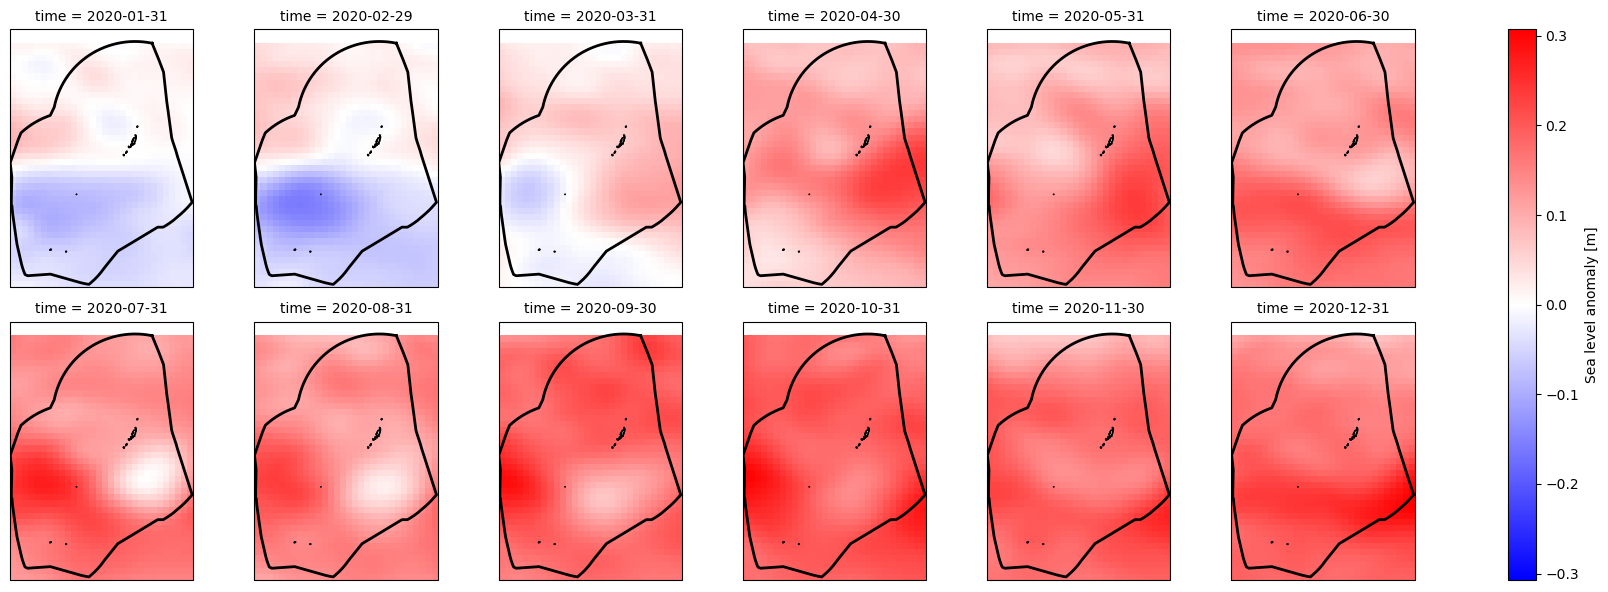

In [35]:
# Plot it!

g = sla_evolution.plot(transform=ccrs.PlateCarree(),
                        col="time",     
                        col_wrap=6, cmap='bwr',
                        subplot_kws={"projection": ccrs.PlateCarree()}
                        )                                       # plot the data

for ax in g.axes.flat:
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')
    # ax.set_extent([minlon+1, maxlon-1, minlat+1, maxlat-1])
    # ax.gridlines(draw_labels=True)
    ax.left_labels = False
    ax.top_labels = False

    #draw EEZ boundary from palau
    for i in palau['features']:
        for j in i['geometry']['coordinates']:
            for k in j:
                ax.plot([l[0] for l in k], [l[1] for l in k], color='k', linewidth=2, transform=ccrs.PlateCarree())


In [46]:
sla

<xarray.DataArray 'sla' (time: 398, latitude: 40, longitude: 30)>
[477600 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float32 1.625 1.875 2.125 2.375 ... 10.88 11.12 11.38
  * longitude  (longitude) float32 129.6 129.9 130.1 130.4 ... 136.4 136.6 136.9
  * time       (time) datetime64[ns] 2019-12-01 2019-12-02 ... 2021-01-01
Attributes:
    ancillary_variables:  err_sla
    comment:              The sea level anomaly is the sea surface height abo...
    grid_mapping:         crs
    long_name:            Sea level anomaly
    standard_name:        sea_surface_height_above_sea_level
    units:                m
    _ChunkSizes:          [1, 50, 50]